# Noise Map

In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import ElevationHandler, A_weighting, import_point_source_data, calc_extent, solve_noise_map
import numpy as np
import matplotlib.pyplot as plt
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs
import pandas as pd

## ISO 9613-2: Calculation of Noise from Wind Turbines
ISO 9613-2 is an international standard that provides guidelines for the calculation of outdoor sound propagation from industrial sources {cite:p}`iso_9613_2`. The widely utilized engineering model outlined in the International Standard provides a simplified and structured approach for calculating sound propagation in accordance with legal requirements. While the model does not explicitly consider diverse meteorological conditions or allow for customized calculations based on wind speed, wind direction, or temperature gradients, it effectively addresses the majority of parameter variations through the predicted mean sound pressure level. Consequently, it is commonly employed to describe downwind propagation or sound transmission under well-developed moderate ground-based temperature inversions.

This implementation of the standard incorporates four distinct forms of attenuation: geometric spreading attenuation from the point source ($A_{div}$), atmospheric absorption attenuation ($A_{atm}$), attenuation due to ground effects ($A_{gr}$), and attenuation resulting from barriers like terrain ($A_{bar}$). These attenuations are combined such that the total attenuation is given by:

$$A = A_{div} + A_{atm} + A_{gr} + A_{bar}$$

In this model, wind turbines are treated as point sources of noise emission, located at the hub of each turbine. The model considers the sound power level for each octave band of each point source. The noise level for each map tile is then calculated as:

$$ L_{AT} = 10 \cdot \log_{10}\left(\sum_{i=1}^n\left(\sum_{j=1}^8 10^{0.1(L_{fT}(ij) + A_f(j))}\right)\right)$$

Here, $L_{fT}$ represents the sound power level of the individual point source for each octave band:

$$L_{fT} = L_W - A$$

$A_f$ denotes the A-weighting function that ensures normalization to 0 dB at a frequency of 1000 Hz, and can be calculated as such:

$$
    R_a(f) = \frac{{12194^2 \cdot f^4}}{{(f^2 + 20.6^2) \cdot \sqrt{{(f^2 + 107.7^2) \cdot (f^2 + 737.9^2)}} \cdot (f^2 + 12194^2)}}
$$

$$
    A(f) = 20 \cdot \log_{10}(R_{af}) + 2.00
$$

As seen below, the A-weighting mostly impacts the influence of the lower frequencies.

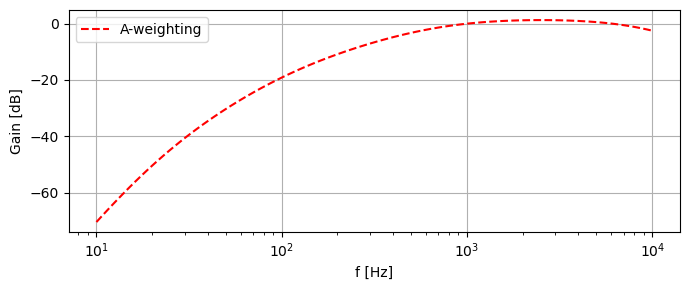

In [2]:
f = np.logspace(1, 4, 100, endpoint=True)
Af = A_weighting(f)
fig, axes = plt.subplots(figsize = (7,3))
axes.semilogx(f, Af, "r--", label = "A-weighting")
axes.set(xlabel = "f [Hz]",
       ylabel = "Gain [dB]")
axes.grid()
axes.legend()
plt.tight_layout()

## Test of function
Below a few instances of noise calculations for various wind parks, each with distinct input parameters.
### Wind Park Svanninge Bjerge (Fictive)
Fictive wind farm situated in the hills of Svanninge Bjerge in Faaborg, Denmark. Unrealistically low turbines were employed for the simulation to highlight the effects of barrier attenuation in the model. A ground factor of 0.5 was applied.

In [3]:
point_source_data = pd.DataFrame(data=[
    {
        "latitude": 55.124232837087455,
        "longitude": 10.270998350214546,
        "h": 20,
        "octave_band": {
            "63": 90.0,
            "125": 95.0,
            "250": 100.0,
            "500": 102.5,
            "1000": 104.0,
            "2000": 98.5,
            "4000": 93.0,
            "8000": 89.5
        }
    },
    {
        "latitude": 55.12513732938618,
        "longitude": 10.264118289154899,
        "h": 30,
        "octave_band": {
            "63": 88.0,
            "125": 92.5,
            "250": 98.0,
            "500": 101.0,
            "1000": 105.5,
            "2000": 97.0,
            "4000": 91.5,
            "8000": 88.0
        }
    },
    {
        "latitude": 55.12851309352396,
        "longitude": 10.268908586941558,
        "h": 25,
        "octave_band": {
            "63": 85.0,
            "125": 90.0,
            "250": 95.5,
            "500": 100.0,
            "1000": 102.0,
            "2000": 96.5,
            "4000": 92.0,
            "8000": 89.0
        }
    }
])
map_shape = [100, 100]
dist = 1500
map_boundaries = calc_extent(point_source_data, dist)
elevation_handler = ElevationHandler(map_boundaries, map_shape)
LDW = solve_noise_map(elevation_handler, point_source_data, ground_factor = 0.5)

File does not exist.


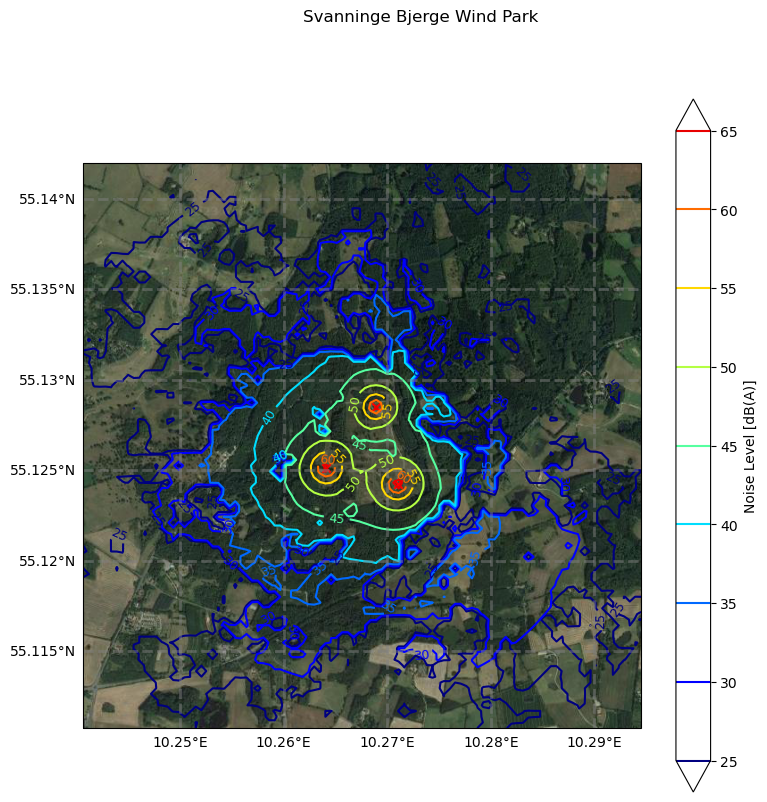

In [4]:
vmin = 25
vmax = float('%.2g' % np.max(LDW)) # round down to two significant digits
levels = np.arange(vmin, vmax, 5)

plt.figure(figsize=(9, 9))
imagery = GoogleTiles(style = "satellite")
ax = plt.axes(projection=imagery.crs)
ax.set_extent(map_boundaries)
cp = ax.contour(elevation_handler.long_range, elevation_handler.lat_range, LDW, 
                alpha = 1, cmap = "jet", transform=ccrs.PlateCarree(),
                levels = levels, vmin = vmin, vmax = vmax, extend = "both")
ax.scatter(point_source_data.longitude, point_source_data.latitude, marker = "x", color = "red", transform=ccrs.PlateCarree())
plt.colorbar(cp, ax = ax, label = "Noise Level [dB(A)]")
plt.clabel(cp, fontsize = 9, inline=1)
ax.add_image(imagery, 14) # 16
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.suptitle("Svanninge Bjerge Wind Park")
plt.tight_layout
plt.show()

### Wind Park Prøvestenen
Prøvestenen Wind Park is a wind facility situated in Copenhagen, Denmark, featuring 3 turbines with a total capacity of 6.0 MW. The specific turbine models and hub heights are Vestas V80-2.0 MW VCS Mark 7. The wind park was established in 2013. In compliance with the Vindmøllebekendtgørelsen noise regulations {cite:p}`noise_law`, the Jupyter Notebook simulations uses a temperature of 10°C, a relative humidity of 80%, and a receiver height of 1.5 meters. The computations for Prøvestenen Wind Park were done with a ground factor of $G = 0.0$ to closely align with the calculation methods prescribed in the Vindmøllebekendtgørelsen.


In [5]:
dist = 1500
point_source_data = import_point_source_data("Prøvestenen_noise.json")
map_boundaries = calc_extent(point_source_data, dist)
map_shape = [100, 100]
map_boundaries = calc_extent(point_source_data, dist)
elevation_handler = ElevationHandler(map_boundaries, map_shape)
LDW = solve_noise_map(elevation_handler, point_source_data, ground_factor = 0, temp = 10, rh = 80, receiver_height=1.5)

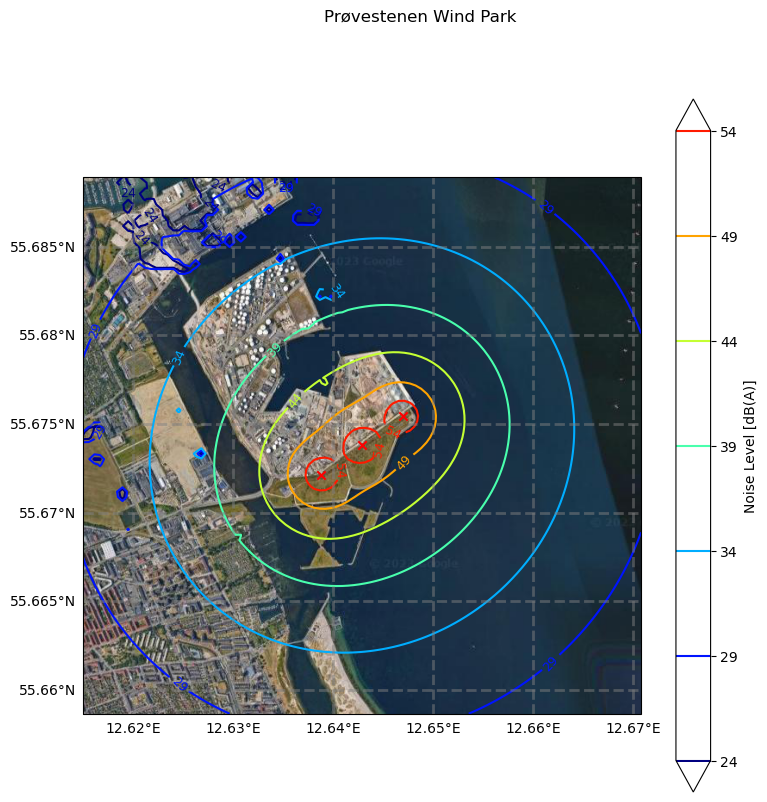

In [6]:
vmin = 24
vmax = float('%.2g' % np.max(LDW)) 
levels = np.arange(vmin, vmax, 5)

plt.figure(figsize=(9, 9))
imagery = GoogleTiles(style = "satellite")
ax = plt.axes(projection=imagery.crs)
ax.set_extent(map_boundaries)
cp = ax.contour(elevation_handler.long_range, elevation_handler.lat_range, LDW, 
                alpha = 1, cmap = "jet", transform=ccrs.PlateCarree(),
                levels = levels, vmin = vmin, vmax = vmax, extend = "both")
ax.scatter(point_source_data.longitude, point_source_data.latitude, marker = "x", color = "red", transform=ccrs.PlateCarree())
plt.colorbar(cp, ax = ax, label = "Noise Level [dB(A)]")
plt.clabel(cp, fontsize = 9, inline=1)
ax.add_image(imagery, 14) # 16
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.suptitle("Prøvestenen Wind Park")
plt.tight_layout
plt.show()

#### Comparison with Prøvestenen EIA
The environmental impact assessment conducted for Prøvestenen utilized WindPRO version 2.7.999 Beta for the calculations, employing the methodologies outlined in the Vindmøllebekendtgørelsen noise regulations {cite:p}`noise_law`.

<img src="../../jupyter-book/images/prøvestenen.jpg" alt="prøvestenen" width="800px" class="bg-primary"/>

*Fig 1: Calculated noise propagation for the turbines at a wind speed of 8 m/s (Source: {cite:p}`provestenen`).*

### Wind Park Juurakko
Juurakko Wind Park is a 40 MW wind facility located in Kalajoki, Finland, featuring 7 Nordex N163 5.7 MW turbines with a hub height of 148 meters, built in 2022 {cite:p}`juurakko`. The calculations are done using a ground factor of $G = 0.4$ and using a receiver height of 4 meters.

In [7]:
map_boundaries = [24.025, 24.2, 64.285, 64.37] 
point_source_data = import_point_source_data("Juurakko.json")
map_shape = [100, 100]
elevation_handler = ElevationHandler(map_boundaries, map_shape)
LDW = solve_noise_map(elevation_handler, point_source_data, ground_factor = 0.4, temp = 15, rh = 70, receiver_height=4)

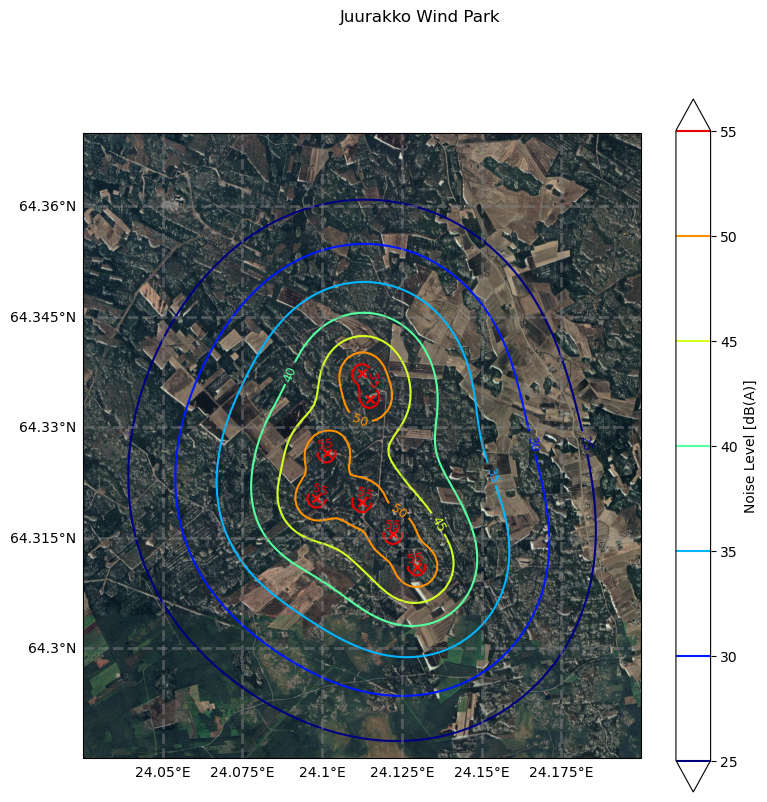

In [8]:
vmin = 25
vmax = float('%.2g' % np.max(LDW)) # round down to two significant digits
levels = np.arange(vmin, vmax, 5)

plt.figure(figsize=(9, 9))
imagery = GoogleTiles(style = "satellite")
ax = plt.axes(projection=imagery.crs)
ax.set_extent(map_boundaries)
cp = ax.contour(elevation_handler.long_range, elevation_handler.lat_range, LDW, 
                alpha = 1, cmap = "jet", transform=ccrs.PlateCarree(),
                levels = levels, vmin = vmin, vmax = vmax, extend = "both")
ax.scatter(point_source_data.longitude, point_source_data.latitude, marker = "x", color = "red", transform=ccrs.PlateCarree())
plt.colorbar(cp, ax = ax, label = "Noise Level [dB(A)]")
plt.clabel(cp, fontsize = 9, inline=1)
ax.add_image(imagery, 14) # 16
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.suptitle("Juurakko Wind Park")
plt.tight_layout
plt.show()

#### Comparison with Juurakko EIA
As an integral step in the wind farm planning process, an environmental impact assessment was conducted. This assessment utilized ISO 9613-2 for predicting the noise levels generated by the turbines. The noise assessment conducted in the study by Juurakko utilized WindPro v3.3 {cite:t}`windpro`. This software automatically applies a 2 dB penalty for each turbine when the base height level between the turbine and receptor exceeds 60 meters. This penalty is directly incorporated into the .json file, resulting in an assigned noise level of 110.7 dB for each turbine.

<img src="../../jupyter-book/images/juurakko.jpg" alt="juurakko" width="800px" class="bg-primary"/>

*Fig 2: Calculated noise propagation for the turbines at 107.2 dB(A) + 1.5 dB(A) (Source: {cite:p}`juurakko`).*